In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.541706  0.167644  0.414285 -0.198819  0.085622  0.404570 -0.021834   
  1  -0.267801  0.039619 -0.223200  0.836172 -0.161906  0.422846  0.262155   
  2   0.386990 -0.216891 -0.140186  0.654678  0.797750  0.045569  0.040667   
  3   0.264472  0.190173  0.047262 -0.508358  0.124718 -0.978041  0.320141   
  4  -1.181738 -0.319288 -0.232604 -0.313622 -0.942817  0.478561 -0.049366   
  5  -1.518302 -0.667989  0.375165  0.810275  1.131443  0.322690  0.199083   
  6  -0.650118 -0.383875  0.122564 -1.128127  0.252126 -0.338672  0.318967   
  7  -0.210847  0.446790 -0.426540 -0.514251  0.834760  0.074642  0.014221   
  8  -1.076139 -0.272364  0.268085 -0.481476 -0.062221  0.174931  0.441662   
  9  -0.236646  0.450654 -0.138735  0.721402  0.149450 -0.300506 -0.282883   
  10 -0.326829 -0.358403 -0.150813  0.452386  0.607055  0.517881  0.024115   
  11  0.853824 -0.325627 -0.701948 -0.373397 -0.815485  0.246841 -0.278780   
  12 -1.479622 -1.185288 -0.613532 -0.331217 -0.292544 -0.305780 -0.883543   
  13 -0.013739 -0.160300 -0.826500 -1.151683 -0.381301 -1.282822  0.310648   
  14 -0.619523  0.100859 -0.622439 -0.340194  0.293955 -0.145728 -0.817327   
  15 -0.973406 -0.362837 -0.829066 -0.882862  0.198263  0.932887  0.180545   
  16 -0.058481 -0.283333 -0.739252 -0.835222 -0.336008  0.137463 -0.143835   
  17 -0.533828 -0.568357 -0.007496 -0.907921 -1.564784 -0.129497 -0.287970   
  18 -0.972562 -0.656277 -0.561229 -0.792720 -0.423184  0.513242  0.305301   
  19 -0.194836  0.144546 -0.981138 -1.126444  0.455870 -0.279391  0.233961   
  20  0.400980 -0.157151 -0.184894 -1.179851 -0.230735 -0.246450  0.106062   
  21 -1.486103 -0.626767 -1.897291 -0.503490 -0.189978  0.059151  1.398497   
  22 -0.314206  0.179120  0.828444 -0.077522 -0.977233 -0.421360  0.330949   
  23 -0.906507 -0.292609 -0.744480 -0.400512 -0.786606 -0.367109  0.319870   
  24 -0.430944  0.009642  0.157736  1.131805  0.973485 -0.020076 -0.437782   
1 0  -0.064535 -0.922405 -0.181205 -0.481170 -0.497481 -0.529649 -0.854631   
  1  -0.629620 -0.784388  0.610870  1.554204  0.251251 -0.660469 -0.578817   
  2   0.386797 -0.470070  0.684242  0.819937  0.413465 -0.330790  0.687820   
  3   0.797149  0.133101 -0.963617 -1.192891 -0.957528  0.462180  0.213756   
  4  -0.508327  0.046815  0.135378  0.393750  0.132954 -0.447775 -1.020305   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.353450  1.306107  0.154165  ... -0.795843 -0.178890  0.283728   
  1  -0.620443 -1.377268 -1.074659  ...  0.752691  0.398590  0.544751   
  2   0.520566  1.249067  1.197724  ... -0.564619 -0.754718  0.279672   
  3   0.837168 -0.305064 -0.025075  ...  0.167072  0.111847  1.317185   
  4   0.269255  0.321599  0.599537  ... -0.142376  0.170750  0.920597   
  5   1.050549  0.237391  0.570164  ... -0.654761  0.022134  0.574359   
  6   0.672739  0.482717  0.207731  ... -0.425530 -0.516291  0.171237   
  7   0.086228  0.561659 -0.227495  ... -0.155857  0.513755  0.119561   
  8   0.832427  0.608797 -0.211601  ...  0.524571 -0.185598  0.074219   
  9  -0.501245  0.025655  0.208560  ... -0.506235  0.000253  1.214644   
  10  1.389778  0.953962 -0.216375  ...  0.148931  0.360293  0.945128   
  11  1.206122  1.485926  0.053750  ... -0.084053  0.394039  0.694698   
  12  0.480845  0.181660  0.584874  ...  0.758194 -1.180785 -0.305947   
  13  0.543004 -0.013591 -0.024132  ...  0.384324  0.043914 -0.398973   
  14  0.218199 -0.119258 -0.485489  ...  0.086099 -0.312005  0.582893   
  15  0.677894  0.063460 -0.577062  ... -0.355085 -0.524545  0.370230   
  16  1.563396  1.226808 -0.027415  ...  0.172992 -0.024576  0.976506   
  17  0.501429  0.032507 -0.142162  ...  0.223422 -0.154345  1.005174   
  18 -0.216583 -0.240290 -0.207992  ...  0.523453 -0.729560  0.130013   
  19  1.572390 -0.137434 -0.011603  ...  0.062431 -0.971745 -1.108259   
  20  0.762189  0.958119  1.072884  ... -0.393952 -0.533928 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.083946  0.041732  25.974103  9.716318e-149  1.002154  1.165739


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



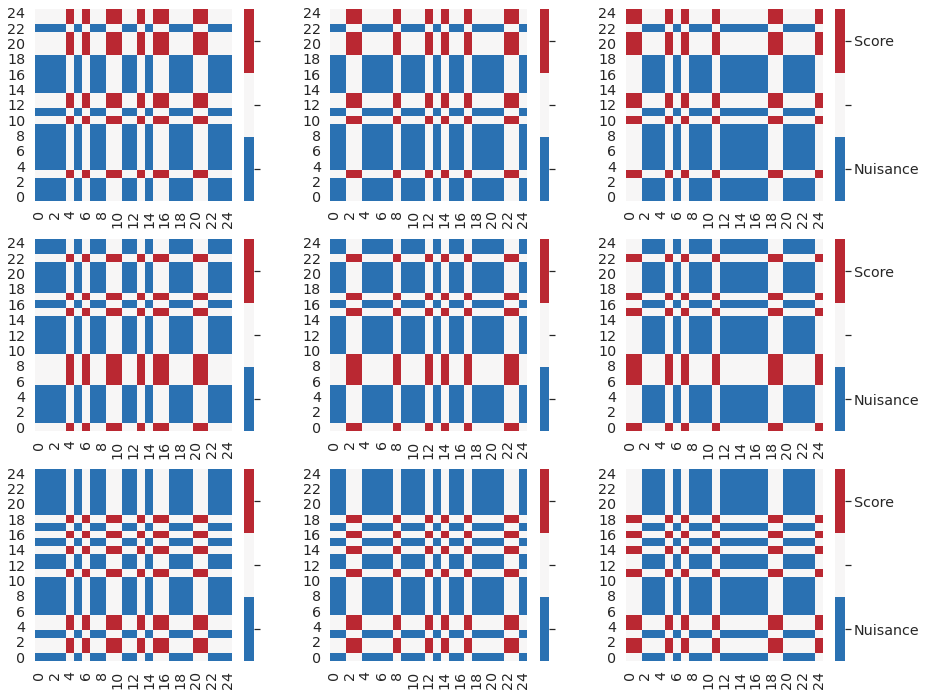

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



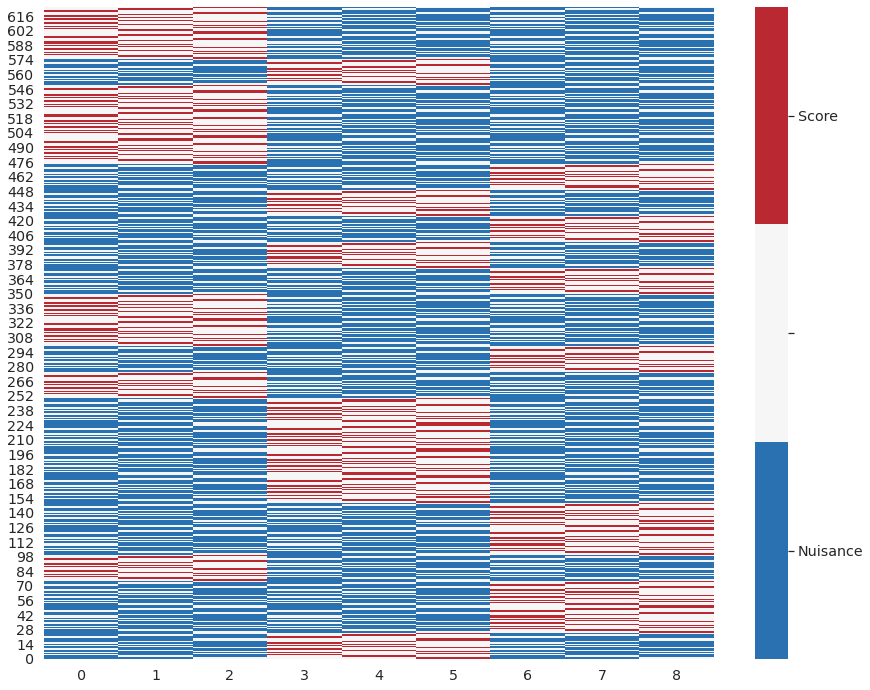

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])